In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import numpy as np
from scipy.interpolate import griddata, interp2d
import scipy.ndimage as ndimage
import os

from lsst.daf.butler import Butler

import sys
sys.path.append('/gpfs/slac/kipac/fs1/u/esteves/codes/treeRingAnalysis/mixcoatl/python/')

from mixcoatl.gridCalibrationTask import GridCalibrationTask
from mixcoatl.gridFitTask import GridFitTask
from mixcoatl.sourcegrid import DistortedGrid


def planefit2d(x, y, z):
    G = np.zeros((x.size, 3))
    G[:, 0] = 1.
    G[:, 1] = x
    G[:, 2] = y
    
    coeff, residues, rank, singval = np.linalg.lstsq(G, z)
    return coeff, residues, rank, singval

def planeval2d(x, y, m):
    
    z = np.zeros_like(x)
    
    z = m[0] + m[1]*x + m[2]*y
    
    return z
    

# Full Raft Testing

In [2]:
repo = '/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/butler.yaml'
butler = Butler(repo)
registry = butler.registry

for collection in registry.queryCollections():
    print(collection)

LSSTCam/raw/all
u/youtsumi/calib/bias/run_12781
u/youtsumi/calib/bias/run_12781/20210524T171403Z
u/youtsumi/calib/bias/run_12781/20210524T182233Z
u/youtsumi/calib/bias/run_12781/20210524T185436Z
LSSTCam/calib
LSSTCam/calib/unbounded
u/youtsumi/calib/bias/run_12781/20210524T193644Z
u/youtsumi/calib/bias/run_12781/20210524T214331Z
u/youtsumi/calib/bias/run_12781/20210524T224535Z
u/youtsumi/calib/bias/run_12781/20210525T004846Z
u/youtsumi/calib/bias/run_12781/20210525T163108Z
u/youtsumi/calib/bias/run_12781/20210525T170205Z
u/jchiang/calib/bias/run_12781
u/jchiang/calib/bias/run_12781/20210525T184949Z
/calib/run_12781
u/youtsumi/calib/dark/run_12781
u/youtsumi/calib/dark/run_12781/20210526T043740Z
u/youtsumi/calib/dark/run_12781/20210526T043948Z
u/youtsumi/calib/defects/run_12781
u/youtsumi/calib/defects/run_12781/20210526T044742Z
u/youtsumi/calib/defects/run_12781/20210526T045217Z
u/youtsumi/spot/1st
u/youtsumi/spot/1st/20210526T052357Z
u/abrought/run_12781/bf
u/abrought/run_12781/bf/202

Summary of Collections:

* `u/asnyder/spot/e2v_analysis` = A CHAINED collection for the spot grid analysis run on all spot grid images.
* `u/asnyder/spot/e2v_analysis_good` = A TAGGED collection of spot grid images free of data corruption.
* `u/asnyder/spot/e2v_analysis_run2` = A CHAINED collection for the spot grid analysis run on spot grid images free of data corruption contained in `u/asnyder/spot/e2v_analysis_good`.
* `u/asnyder/spot/e2v_calibration_run2` = A CHAINED collection for the grid calibration using `u/asnyder/spot/e2v_analysis_run2` output datasets.
* `u/asnyder/spot/e2v_calib` = A CALIBRATION collection containing the grid calibration output from `u/asnyder/spot/e2v_calibration_run2`.
* `u/asnyder/spot/e2v_analysis_run3` = A CHAINED collection for the spot grid analysis run on spot grid images free of data corruption contained in `u/asnyder/spot/e2v_analysis_good` and using the grid calibration from `u/asnyder/spot/e2v_calib`.
* `u/asnyder/spot/e2v_analysis_curated` = A TAGGED collection of spot grid images near the center of the CCD (no data corruption).
* `u/asnyder/spot/e2v_analysis_run4` = A CHAINED collection for the spot grid analysis and grid calibration on spot grid images near the center of the CCD, contained in `u/asnyder/e2v_analysis_curated`.
* `u/asnyder/spot/e2v_calibration_run4` = A CHAINED collection for the grid calibration using `u/asnyder/spot/e2v_analysis_run4` output datasets.
* `u/asnyder/spot/e2v_calib_curated` = A CALIBRATION collection containing the grid calibration output from `u/asnyder/spot/e2v_calibration_run4`.
* `u/asnyder/spot/e2v_analysis_run5` = A CHAINED collection for the spot grid analysis run on spot grid images free of data corruption contained in `u/asnyder/spot/e2v_analysis_good` and using the grid calibration from `u/asnyder/spot/e2v_calib_curated`.

To Do:

1. Make a TAGGED collection with curated spot grid images.
2. Make a new RUN collection for a grid calibration construction from the curated spot grid images.
3. Make a new CALIB collection for the new grid calibration.
3. Make a new RUN collection for the spot grid analysis run on spot grid images free of data corruption, using the new grid calibration.


## Grid Fit Dataset Validation

In [3]:
collections = 'u/asnyder/spot/e2v_analysis_run3'

dataset_refs = list(registry.queryDatasets('gridSpotSrc', collections=collections))
dataset_refs = sorted(dataset_refs, key=lambda x : x.dataId['exposure'])
print(len(dataset_refs))

1827


In [4]:
# bot_x0 = np.full(len(dataset_refs), np.nan)
# bot_y0 = np.full(len(dataset_refs), np.nan)

# grid_x0 = np.full(len(dataset_refs), np.nan)
# grid_y0 = np.full(len(dataset_refs), np.nan)
# grid_xstep = np.full(len(dataset_refs), np.nan)
# grid_ystep = np.full(len(dataset_refs), np.nan)
# grid_theta = np.full(len(dataset_refs), np.nan)

# spot_x = np.full(len(dataset_refs), np.nan)
# spot_y = np.full(len(dataset_refs), np.nan)

# dist = np.full(len(dataset_refs), np.nan)

# index = 49*24+24

# good = []

# for i, ref in enumerate(dataset_refs):
#     print('%i/%i'%(i,len(dataset_refs)))
#     catalog = butler.get(ref, collections=collections)
#     md = catalog.getMetadata()
        
#     bot_x0[i] = md['BOTXCAM']
#     bot_y0[i] = md['BOTYCAM']
    
#     grid_x0[i] = md['GRID_X0']
#     grid_y0[i] = md['GRID_Y0']
#     grid_xstep[i] = md['GRID_XSTEP']
#     grid_ystep[i] = md['GRID_YSTEP']
#     grid_theta[i] = md['GRID_THETA']
    
#     dist[i] = np.sqrt(np.square(grid_x0[i]-512*4.) + np.square(grid_y0[i]-2001.))
    
#     if (dist[i] < 500.):
#         good.append(i)
    
#     select = catalog['spotgrid_index'] == index
#     if len(catalog['base_SdssCentroid_x'][select]) == 1:
#         spot_x[i] = catalog['base_SdssCentroid_x'][select][0]
#         spot_y[i] = catalog['base_SdssCentroid_y'][select][0]
        
# print(good)

In [5]:
# select = ~np.isnan(spot_x)

# fig, ax = plt.subplots(1, 1, figsize=(12, 10))
# ax.scatter(bot_y0, spot_x)
# ax.grid()
# ax.set_ylabel('Spot X [pixels]', fontsize=16)
# ax.set_xlabel('BOT Y [mm]', fontsize=16)
# fig.patch.set_facecolor('white')
# ax.set_title('Grid Fit Diagnostic: Run 12784', fontsize=16)
# plt.savefig('gridfit_diagnostic_12784.png')

In [6]:
# # definitions for the axes
# left, width = 0.1, 0.65
# bottom, height = 0.1, 0.65
# spacing = 0.005

# rect_scatter = [left, bottom, width, height]
# rect_histx = [left, bottom + height + spacing, width, 0.2]
# rect_histy = [left + width + spacing, bottom, 0.2, height]

# # start with a square Figure
# fig = plt.figure(figsize=(14, 10))

# ax = fig.add_axes(rect_scatter)
# ax_histx = fig.add_axes(rect_histx, sharex=ax)
# ax_histy = fig.add_axes(rect_histy, sharey=ax)

# ax.scatter(grid_x0, grid_y0, c=dist)
# ax.set_ylabel('Grid Center Y', fontsize=14)
# ax.set_xlabel('Grid Center X', fontsize=14)
# ax.grid(True, which='major', axis='both')

# ax_histx.tick_params(axis="x", labelbottom=False)
# ax_histy.tick_params(axis="y", labelleft=False)

# ax_histx.hist(grid_x0, bins=40)
# ax_histy.hist(grid_y0, bins=40, orientation='horizontal')

## Initial Calibration

This initial calibration was made from a small curated set of projector images where the the center of the projected spot grid was close to the center of the CCD.  This was done in order to minimize any bias in the model fit due to having a significant fraction of the spots fall outside of the image.

In [7]:
collections = 'u/asnyder/spot/e2v_calibration_run4/20210928T192110Z'

dataset_refs = list(registry.queryDatasets('gridCalibration', collections=collections))

In [9]:
# ## Get calibration table/grid
# calib_table = butler.get(dataset_refs[0], collections=collections)
# calib_grid = DistortedGrid.from_astropy(calib_table)

# gy, gx = calib_grid.get_centroids()
# dy, dx = calib_grid.get_centroid_shifts()

# fig, ax = plt.subplots(1, 1, figsize=(12, 10))
# Q = ax.quiver(gx, gy, dx, dy)
# qk = ax.quiverkey(Q, 0.9, 0.9, 2, r'2 pixels', labelpos='E')
# ax.grid(True, which='major', axis='both')
# fig.patch.set_facecolor('white')

## Calculate Sensor Effects

In [10]:
import os

run = not os.path.isfile('tmp/x_results.npy')

In [11]:
if run:
    collections = 'u/asnyder/spot/e2v_analysis_run5'

    dataset_refs = list(registry.queryDatasets('gridSpotSrc', collections=collections))
    dataset_refs = sorted(dataset_refs, key=lambda x : x.dataId['exposure'])
    print(len(dataset_refs))

    calib_grid = calib_grid
    calib_table = calib_table

    num_catalogs = len(dataset_refs)

    x_results = np.zeros(49*49*num_catalogs)
    y_results = np.zeros(49*49*num_catalogs)
    dx_results = np.zeros(49*49*num_catalogs)
    dy_results = np.zeros(49*49*num_catalogs)
    dxx_results = np.zeros(49*49*num_catalogs)
    dyy_results = np.zeros(49*49*num_catalogs)

    ## Aggregate individual image residual results
    for i, ref in enumerate(dataset_refs):
        print('%i/%i'%(i,len(dataset_refs)))
        ## Select a catalog
        source_catalog = butler.get(ref, collections=collections)
        source_grid = DistortedGrid.from_astropy(source_catalog.asAstropy())

        ## Get centroid shifts
        norm_dy = source_grid.norm_dy - calib_grid.norm_dy
        norm_dx = source_grid.norm_dx - calib_grid.norm_dx
        dy, dx = source_grid.convert_normalized_shifts(norm_dy, norm_dx)

        ## Plane Model fit to residuals
        gy, gx = source_grid.get_centroids()
        indices = ~np.isnan(dx)
        dx_coeff,residues,rank,singval = planefit2d(gx[indices], gy[indices], dx[indices])
        dx_model = planeval2d(gx, gy, dx_coeff)
        dx = dx-dx_model

        indices = ~np.isnan(dy)
        dy_coeff,residues,rank,singval = planefit2d(gx[indices], gy[indices], dy[indices])
        dy_model = planeval2d(gx, gy, dy_coeff)
        dy = dy-dy_model

        ## Get shape distortions
        indices = source_catalog['spotgrid_index']
        select = indices >= 0.
        xx = np.full(49*49, np.nan)
        yy = np.full(49*49, np.nan)

        xx[indices[select]] = source_catalog['base_SdssShape_xx'][select]
        yy[indices[select]] = source_catalog['base_SdssShape_yy'][select]
        dxx = xx - calib_table['base_SdssShape_xx']
        dyy = yy - calib_table['base_SdssShape_yy']

        ## Add optical shifts to position
        y, x = source_grid.get_centroids()
        calib_dy, calib_dx = source_grid.convert_normalized_shifts(calib_grid.norm_dy, calib_grid.norm_dx)
        y += calib_dy
        x += calib_dx

        ## Output data arrays
        dx_results[i*49*49:(i+1)*49*49] = dx
        dy_results[i*49*49:(i+1)*49*49] = dy
        dxx_results[i*49*49:(i+1)*49*49] = dxx
        dyy_results[i*49*49:(i+1)*49*49] = dyy
        x_results[i*49*49:(i+1)*49*49] = x
        y_results[i*49*49:(i+1)*49*49] = y

In [12]:
if run:
    np.save('tmp/x_results.npy' ,x_results)
    np.save('tmp/y_results.npy' ,y_results)

    np.save('tmp/dx_results.npy',dx_results)
    np.save('tmp/dy_results.npy',dy_results)

    np.save('tmp/dxx_results.npy',dxx_results)
    np.save('tmp/dyy_results.npy',dyy_results)
    
else:
    x_results = np.load('x_results.npy')
    y_results = np.load('y_results.npy')

    dx_results = np.load('dx_results.npy')
    dy_results = np.load('dy_results.npy')

    dxx_results = np.load('dxx_results.npy')
    dyy_results = np.load('dyy_results.npy')

In [13]:
# pixmin = 0
# pixmax = 4000
# xi = yi = np.arange(pixmin,pixmax,2.0)
# xi,yi = np.meshgrid(xi,yi)

# # Interpolate
# DX_im  = griddata((x_results, y_results), dx_results,(xi,yi),method='linear')
# DY_im  = griddata((x_results, y_results), dy_results,(xi,yi),method='linear')
# DXX_im = griddata((x_results, y_results), dxx_results,(xi,yi),method='linear')
# DYY_im = griddata((x_results, y_results), dyy_results,(xi,yi),method='linear')

In [14]:
# fig, ax = plt.subplots(1, 2, figsize=(18, 10))
# im0 = ax[0].imshow(DX_im, origin='lower', vmin=-0.1, vmax=0.1, interpolation='none',
#                    extent=[0, 512*8, 0, 4002])
# im1 = ax[1].imshow(DY_im, origin='lower', vmin=-0.1, vmax=0.1, interpolation='none',
#                    extent=[0, 512*8, 0, 4002])

# ax[0].set_title('X Centroid Shift', fontsize=16)
# ax[0].set_ylabel('CCD Y Position [pixels]', fontsize=14)
# ax[0].set_xlabel('CCD X Position [pixels]', fontsize=14)
# ax[0].tick_params(axis='both', which='major', labelsize=12)
# ax[1].set_title('Y Centroid Shift', fontsize=16)
# ax[1].set_ylabel('CCD Y Position [pixels]', fontsize=14)
# ax[1].set_xlabel('CCD X Position [pixels]', fontsize=14)
# ax[1].tick_params(axis='both', which='major', labelsize=12)

# fig.subplots_adjust(bottom=0.2)
# cbar_ax = fig.add_axes([0.15, 0.1, 0.725, 0.05])
# cbar = fig.colorbar(im0, cax=cbar_ax, orientation='horizontal')
# cbar.ax.tick_params(labelsize=12)
# cbar.set_label('Centroid Shift [pixels]', fontsize=14)
# fig.patch.set_facecolor('white')
# plt.savefig('new_e2v_centroid_shifts.png')

In [15]:
# fig, ax = plt.subplots(1, 2, figsize=(18, 10))
# im0 = ax[0].imshow(DXX_im, origin='lower', vmin=-0.1, vmax=0.1, interpolation='none',
#                    extent=[0, 512*8, 0, 4002])
# im1 = ax[1].imshow(DYY_im, origin='lower', vmin=-0.1, vmax=0.1, interpolation='none',
#                    extent=[0, 512*8, 0, 4002])

# ax[0].set_title('XX Moment', fontsize=16)
# ax[0].set_ylabel('CCD Y Position [pixels]', fontsize=14)
# ax[0].set_xlabel('CCD X Position [pixels]', fontsize=14)
# ax[0].tick_params(axis='both', which='major', labelsize=12)
# ax[1].set_title('YY Moment', fontsize=16)
# ax[1].set_ylabel('CCD Y Position [pixels]', fontsize=14)
# ax[1].set_xlabel('CCD X Position [pixels]', fontsize=14)
# ax[1].tick_params(axis='both', which='major', labelsize=12)

# fig.subplots_adjust(bottom=0.2)
# cbar_ax = fig.add_axes([0.15, 0.1, 0.725, 0.05])
# cbar = fig.colorbar(im0, cax=cbar_ax, orientation='horizontal')
# cbar.ax.tick_params(labelsize=12)
# cbar.set_label(r'Shape Distortion [$\mathrm{pixels}^2$]', fontsize=14)
# fig.patch.set_facecolor('white')
# plt.savefig('new_e2v_shape_distortions.png')

In [16]:
# fig, ax = plt.subplots(1, 1, figsize=(14, 10))
# im = ax.imshow(DXX_im + DYY_im, origin='lower', vmin=-0.1, vmax=0.1, interpolation='none',
#                    extent=[0, 512*8, 0, 4002])

# ax.set_ylabel('CCD Y Position [pixels]', fontsize=14)
# ax.set_xlabel('CCD X Position [pixels]', fontsize=14)
# ax.tick_params(axis='both', which='major', labelsize=12)

# fig.subplots_adjust(bottom=0.2)
# cbar_ax = fig.add_axes([0.15, 0.075, 0.725, 0.05])
# cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
# cbar.ax.tick_params(labelsize=12)
# cbar.set_label(r'T [$\mathrm{pixels}^2$]', fontsize=14)
# fig.patch.set_facecolor('white')
# plt.savefig('new_e2v_T_distortions.png')

In [17]:
# 

In [18]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy="mean")
# DX_im2 = imp.fit_transform(DX_im)
# DY_im2 = imp.fit_transform(DY_im)

In [19]:
# print(DX_im)

In [20]:
# print(DX_im2)

In [21]:
# fig, ax = plt.subplots(1, 2, figsize=(18, 10))

# im0 = ax[0].imshow(DXX_im, origin='lower', vmin=-0.1, vmax=0.1, interpolation='none',
#                    extent=[0, 512*8, 0, 4002])
# im1 = ax[1].imshow(DYY_im, origin='lower', vmin=-0.1, vmax=0.1, interpolation='none',
#                    extent=[0, 512*8, 0, 4002])

# ax[0].set_title('XX Moment', fontsize=16)
# ax[0].set_ylabel('CCD Y Position [pixels]', fontsize=14)
# ax[0].set_xlabel('CCD X Position [pixels]', fontsize=14)
# ax[0].tick_params(axis='both', which='major', labelsize=12)
# ax[1].set_title('YY Moment', fontsize=16)
# ax[1].set_ylabel('CCD Y Position [pixels]', fontsize=14)
# ax[1].set_xlabel('CCD X Position [pixels]', fontsize=14)
# ax[1].tick_params(axis='both', which='major', labelsize=12)

# fig.subplots_adjust(bottom=0.2)
# cbar_ax = fig.add_axes([0.15, 0.1, 0.725, 0.05])
# cbar = fig.colorbar(im0, cax=cbar_ax, orientation='horizontal')
# cbar.ax.tick_params(labelsize=12)
# cbar.set_label(r'Shape Distortion [$\mathrm{pixels}^2$]', fontsize=14)
# fig.patch.set_facecolor('white')
# plt.savefig('new_e2v_shape_distortions.png')

In [45]:
# centers = [[-335.49, 4095.84],[-156,-280],[4320,4180],[4627.47, -630.89]]
centers = [[-335.49, 4095.84],[-156,-280],[4320,4180],[4620., -470.]]
sensor_lims = {'e2v':[[0,4096],[0,4004]],'ITL':[[0,4072],[0,4000]]}


In [46]:
def proj_to_polar_coord(t,vx,vy):
    vr = np.cos(t)*vx + np.sin(t)*vy
    vt = -np.sin(t)*vx+ np.cos(t)*vy
    return vr, vt

def proj_to_polar_coord_spin2(t,vx,vy):
    vr = np.cos(2*t)*vx + np.sin(2*t)*vy
    vt = np.sin(2*t)*vx - np.cos(2*t)*vy
    return vr, vt

def trasnform_to_polar_coord(x,y,x0=0.,y0=0.,deg=False):
    r = np.hypot((x-x0),(y-y0))
    t = np.arctan2((y-y0),(x-x0))
    
    if deg: t *= (180 / np.pi)
    return r,t

In [47]:
xc,yc = centers[3]

r, t = trasnform_to_polar_coord(x_results,y_results, x0=xc, y0=yc)
dr_results,dt_results= proj_to_polar_coord(t,dx_results,dy_results)

In [48]:
pixmin = 0
pixmax = 4000
xi = yi = np.arange(pixmin,pixmax,2.0)
xi,yi   = np.meshgrid(xi,yi)

# Interpolate
# DR_im = griddata((x_results, y_results), dr_results,(xi,yi),method='linear')
# DT_im = griddata((x_results, y_results), dt_results,(xi,yi),method='linear')

In [49]:
# DR_im2 = imp.fit_transform(DR_im)
# DT_im2 = imp.fit_transform(DT_im)

In [50]:
title = 'E2V - 25raft data'

In [51]:
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# imshow(DR_im,axes[0],title='dR',levels=[-0.45/100.,0.45/100.])
# im0 = imshow(DT_im,axes[1],title=r'$d\Theta$',levels=[-0.45/100.,0.45/100.],show_colorbar=True)

# fig.subplots_adjust(bottom=0.2)
# cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.03])
# cbar = fig.colorbar(im0,cax= cbar_ax, orientation='horizontal')
# # cbar.set_label(ylabel, fontsize=18)
# cbar.ax.tick_params(labelsize=12)

# plt.suptitle(title)

In [52]:
from tree_ring_helper import *

def generate_image(x,y,z,MAX=0.07,fradius=140,sensor='e2v'):
    nbins = 400
    bins = [407,400] #approx. 10x10 px^2 binning
    dT_mean, x_edge, y_edge, binidx = binned_statistic_2d(x,y,z, 'mean',
                                                          range=sensor_lims[sensor], bins=bins)
                                                          #mean is significantly faster calculation
    
    ## sensor max limits
    xmax = sensor_lims[sensor][0][1]
    ymax = sensor_lims[sensor][1][1]
    
    ## resize image
    resized     = cv2.resize(dT_mean.T,(xmax,ymax), interpolation = cv2.INTER_AREA)
    
    return dT_mean,resized


In [53]:

_,dx_im = generate_image(x_results,y_results,dx_results,MAX=0.07,fradius=140,sensor='e2v')
_,dy_im = generate_image(x_results,y_results,dy_results,MAX=0.07,fradius=140,sensor='e2v')

_,dxx_im = generate_image(x_results,y_results,dxx_results,MAX=0.07,fradius=140,sensor='e2v')
_,dyy_im = generate_image(x_results,y_results,dyy_results,MAX=0.07,fradius=140,sensor='e2v')

_,dr_im = generate_image(x_results,y_results,dr_results,MAX=0.07,fradius=140,sensor='e2v')
_,dt_im = generate_image(x_results,y_results,dt_results,MAX=0.07,fradius=140,sensor='e2v')

In [54]:
# 
import numpy
import scipy

def block_view(A, block_shape):
    """Provide a 2D block view of a 2D array.
    
    Returns a view with shape (n, m, a, b) for an input 2D array with
    shape (n*a, m*b) and block_shape of (a, b).
    """
    assert len(A.shape) == 2, '2D input array is required.'
    assert A.shape[0] % block_shape[0] == 0, 'Block shape[0] does not evenly divide array shape[0].'
    assert A.shape[1] % block_shape[1] == 0, 'Block shape[1] does not evenly divide array shape[1].'
    shape = np.array((A.shape[0] / block_shape[0], A.shape[1] / block_shape[1]) + block_shape).astype(int)
    strides = np.array((block_shape[0] * A.strides[0], block_shape[1] * A.strides[1]) + A.strides).astype(int)
    return numpy.lib.stride_tricks.as_strided(A, shape=shape, strides=strides)

def apply_filter(A, smoothing, power=2.0):
    """Apply a hi/lo pass filter to a 2D image.
    
    The value of smoothing specifies the cutoff wavelength in pixels,
    with a value >0 (<0) applying a hi-pass (lo-pass) filter. The
    lo- and hi-pass filters sum to one by construction.  The power
    parameter determines the sharpness of the filter, with higher
    values giving a sharper transition.
    """
    if smoothing == 0:
        return A
    ny, nx = A.shape
    # Round down dimensions to even values for rfft.
    # Any trimmed row or column will be unfiltered in the output.
    nx = 2 * (nx // 2)
    ny = 2 * (ny // 2)
    T = np.fft.rfft2(A[:ny, :nx])
    # Last axis (kx) uses rfft encoding.
    kx = np.fft.rfftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kpow = (kx ** 2 + ky[:, np.newaxis] ** 2) ** (power / 2.)
    k0pow = (1. / smoothing) ** power
    if smoothing > 0:
        F = kpow / (k0pow + kpow) # high pass
    else:
        F = k0pow / (k0pow + kpow) # low pass
    S = A.copy()
    S[:ny, :nx] = np.fft.irfft2(T * F)
    return S

def zero_by_region(data, region_shape, num_sigmas_clip=4.0, smoothing=250, power=4):
    """Subtract the clipped median signal in each amplifier region.
    
    Optionally also remove any smooth variation in the mean signal with
    a high-pass filter controlled by the smoothing and power parameters.
    Returns a an array of median levels in each region and a mask of
    unclipped pixels.
    """
    mask = np.zeros_like(data, dtype=bool)

    # Loop over amplifier regions.
    regions = block_view(data, region_shape)
    masks   = block_view(mask, region_shape)
    ny, nx = regions.shape[:2]
    levels = np.empty((ny, nx))
  
    for y in range(ny):
        for x in range(nx):
            region_data = regions[y, x]
            region_mask = masks[y, x]
            clipped1d, lo, hi = scipy.stats.sigmaclip(
                region_data, num_sigmas_clip, num_sigmas_clip)
            # Add unclipped pixels to the mask.
            region_mask[(region_data > lo) & (region_data < hi)] = True            
            # Subtract the clipped median in place.
            levels[y, x] = np.median(clipped1d)
            region_data -= levels[y, x]
            # Smooth this region's data.
            if smoothing != 0:
                clipped_data = region_data[~region_mask]
                region_data[~region_mask] = 0.
                region_data[:] = apply_filter(region_data, smoothing, power)
                region_data[~region_mask] = clipped_data
                
    return levels, mask
def get_diff_lowpass(image, size=250, power=4.0, use_zero=True, geometry=(2,8)):
    if use_zero:
        image1 = image.copy()
        levels,mask = zero_by_region(image1, (image1.shape[0]/geometry[0], image1.shape[1]/geometry[1]))

        return image1#/image
    else:
        diff = apply_filter(image, size, power=power)
    
        return diff#/image

### Tree Ring Analysis

In [55]:
image = imp.fit_transform(dr_im)

In [56]:
ring_e2v = tree_ring_tools(sensor='e2v',loc=3)

ring_e2v.img_cut = 100.*image
ring_e2v.img     = 100.*dr_im
# ring_e2v.diff    = 100.*get_diff_lowpass(image-np.median(image), size=250, power=4.0, use_zero=True)

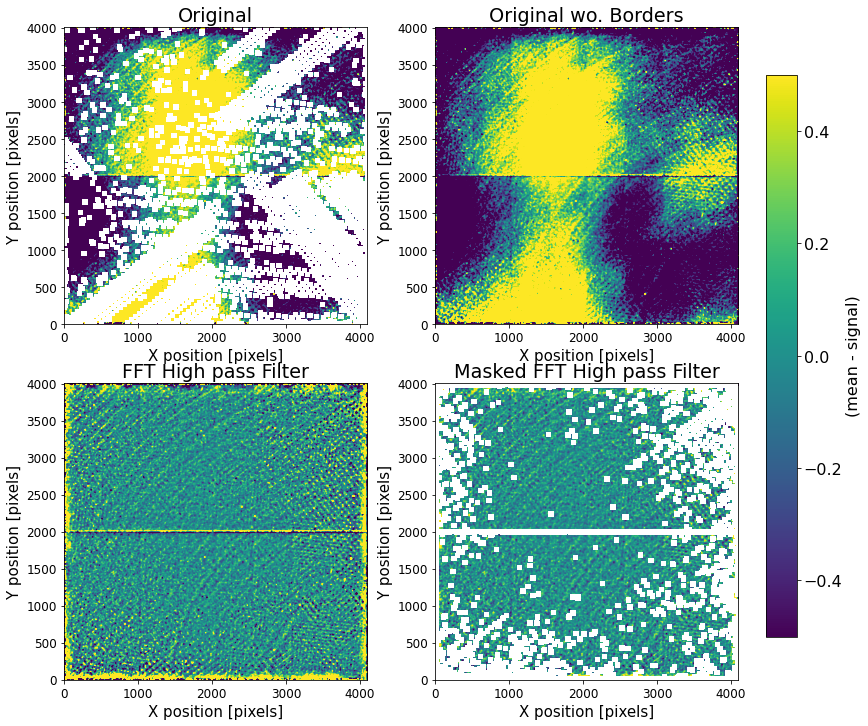

In [79]:
## always run in the following order
ring_e2v.apply_high_freq_filter()
ring_e2v.apply_gaussian_filter(downscale=2)
ring_e2v.apply_mask(downscale=8,threshold=1.75)

# ring_e2v.diff2 = ring_e2v.diff#gaussian_filter(ring_e2v.diff,8)

ring_e2v.set_ylabel(r'(mean - signal)')
ring_e2v.set_levels([-0.5,0.5])
ring_e2v.display_images()

In [80]:
ring_e2v.xc = 4620.
ring_e2v.yc = -470.

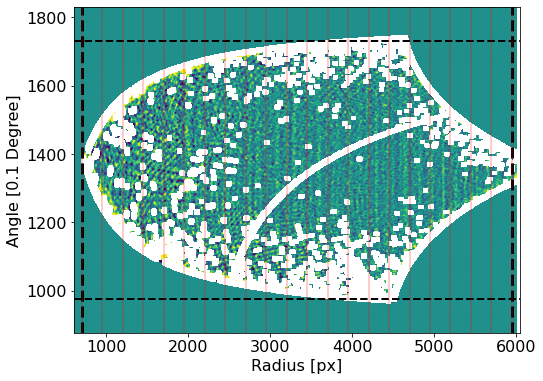

In [81]:
ring_e2v.set_levels([-0.45,0.45])
ring_e2v.theta_min = 1150
ring_e2v.theta_max = 1600
ring_e2v.make_polar_transformation(rborder=20.)
ring_e2v.check_polar_transfomartion(r_cut=[700,5950])
# plt.xlim(2000.,5500)
# plt.ylim(1300,1700)

(3100.0, 5242.0)

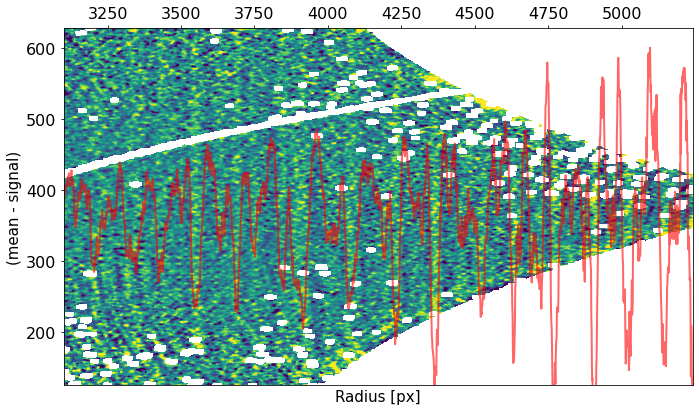

In [82]:
ring_e2v.compute_signal(zeroNan=True)
ring_e2v.plot_superposition_polar_signal()
plt.xlim(3100,)


(-0.45, 0.45)

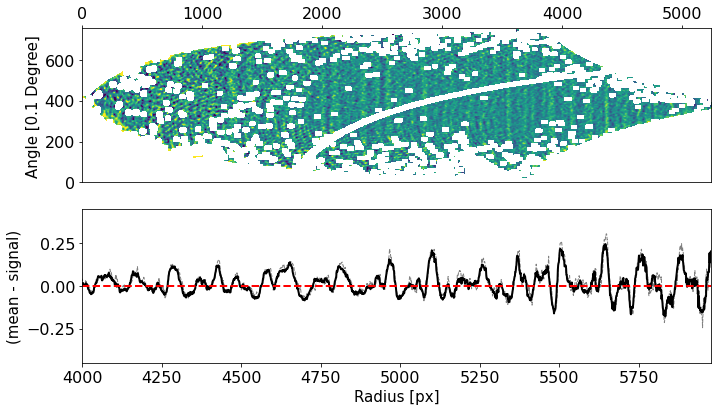

In [83]:
ring_e2v.plot_pannel_image_signal()
plt.xlim(4000,)
plt.ylim(-0.45,0.45)

(-0.5, 0.5)

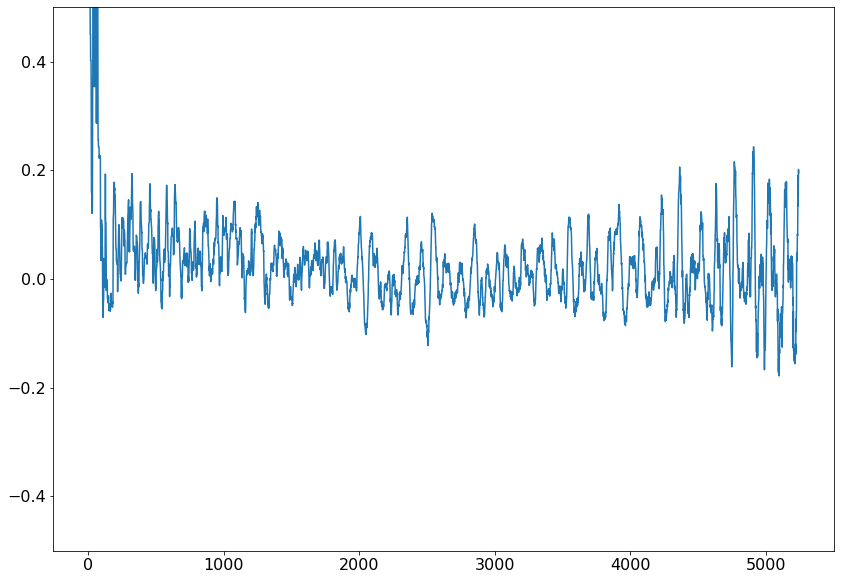

In [86]:
plt.plot(ring_e2v.signal)
# plt.xlim(200,)
plt.ylim(-0.5,0.5)

In [87]:
ring_e2v.save_profile('dr2')

saving: profiles/polar_e2v_dr2.npy


### TR Center Fit

In [121]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(obj=None, ax=None, size="5%", pad=0.1):
    should_restore = False

    if obj is not None:
        ax = obj.axes
    elif ax is None:
        ax = plt.gca()
        should_restore = True

    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)

    plt.colorbar(obj, cax=cax)

    if should_restore:
        plt.sca(ax)
        
def imshow2(image, qq=[0.5,97.5], show_colorbar=True, **kwargs):
    vmin1,vmax1 = np.percentile(image[np.isfinite(image)], qq)
    if 'vmin' not in kwargs.keys():
        kwargs['vmin'] = vmin1
    if 'vmax' not in kwargs.keys():
        kwargs['vmax'] = vmax1
    plt.imshow(image, **kwargs)
    if show_colorbar:
        colorbar()

Text(0.5, 1.0, 'Downscaled and masked circle detection image')

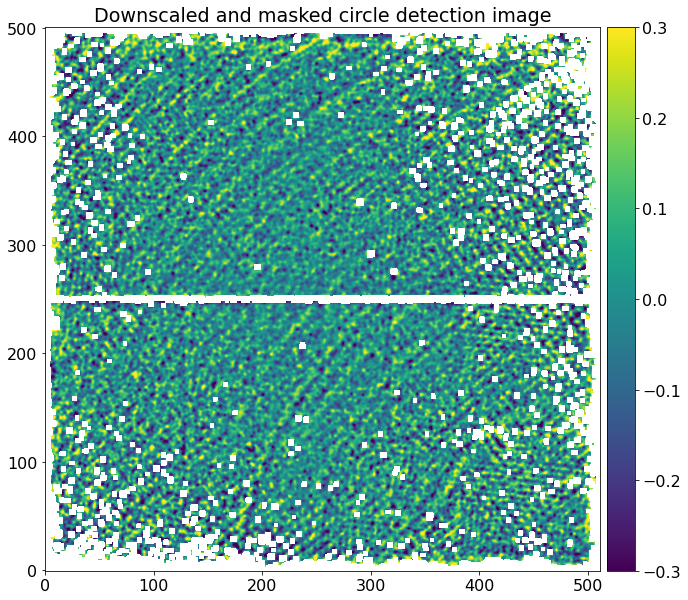

In [80]:
downscale = 8
# threshold = 0.0003 # For faintest rings
# threshold = 0.0005 # For faint rings
threshold = 0.5 # For stronger rings
#threshold = 0.003 # For strongest rings

diff  = ring_e2v.diff
diff1 = gaussian_filter(diff.copy(), 8.)
mask = np.abs(diff1) > threshold
diff2 = block_reduce(diff1, (downscale, downscale), func=np.nanmean)
mask2 = block_reduce(mask , (downscale, downscale), func=np.nanmax)
diff2[mask2] = np.nan

imshow2(diff2, interpolation='bicubic', vmin=-0.3, vmax=0.3)#
plt.title('Downscaled and masked circle detection image')

In [41]:
# Pixel coordinate grid
y2,x2 = np.mgrid[0:diff2.shape[0], 0:diff2.shape[1]]
y,x = np.mgrid[0:diff.shape[0], 0:diff.shape[1]]

def fn_detect(p):
    '''Estimator to locate tree rings center in downscaled images'''
    r = np.hypot(x2-p[0], y2-p[1])
    idx = np.isfinite(diff2) & (diff2 != 0)
    v,bins,_ = binned_statistic(r[idx], diff2[idx], bins=np.arange(np.mean(r), np.max(r), 1.0))
    return -np.std(v[np.isfinite(v)])

def fn_measure(x0, y0, mask=None, step=4.0, statistic='mean'):
    '''Function to measure tree rings in original image given the center'''
    r = np.hypot(x-x0, y-y0)
    idx = np.isfinite(diff) & (diff != 0)
    if mask is not None:
        idx &= ~mask
    v,bins,_ = binned_statistic(r[idx], diff[idx], bins=np.arange(np.min(r), np.max(r), step), statistic=statistic)
    
    return 0.5*(bins[1:]+bins[:-1]), v

NameError: name 'diff2' is not defined

In [82]:
xlow, xhig = 4000., 4800.
ylow, yhig = -800., 0.

import scipy.optimize as opt
cc = opt.differential_evolution(fn_detect,[[xlow/downscale,xhig/downscale],[ylow/downscale,yhig/downscale]], popsize=40)
print(cc)

x0,y0 = cc.x[0]*downscale, cc.x[1]*downscale
print()
print("Original scale coordinates: %.2f, %.2f"%(x0, y0))

     fun: -0.06629015339214223
 message: 'Optimization terminated successfully.'
    nfev: 803
     nit: 9
 success: True
       x: array([581.10336785, -61.15604137])

Original scale coordinates: 4648.83, -489.25


### Period Analysis

In [42]:
pos = ring_e2v.radii
v = ring_e2v.signal

Will analyse the following radial interval: 1894 - 5774 pixels


<ipython-input-43-610f078b0d2b>:17: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1.0/freq, power, '-')


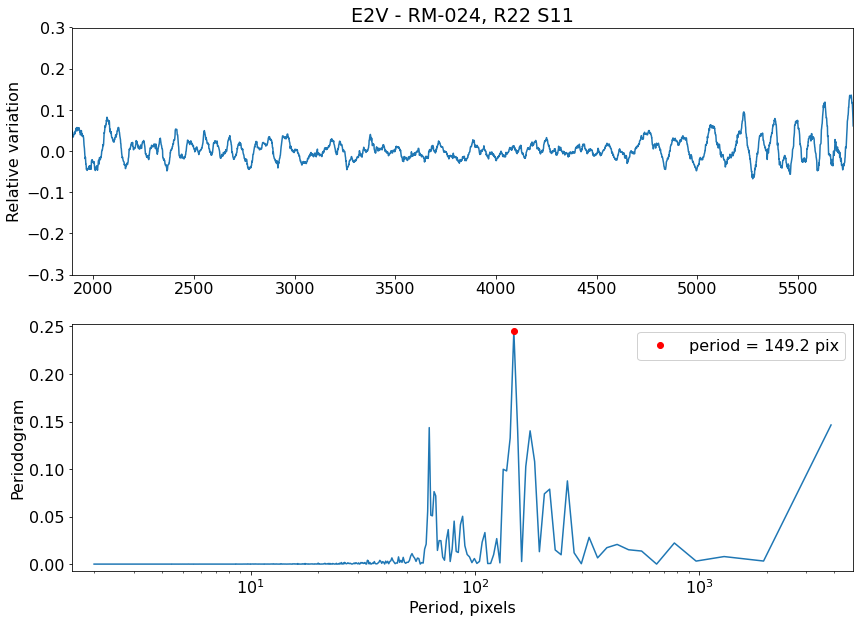

In [43]:
from scipy.signal import periodogram, lombscargle

lo,hi = np.percentile(pos[np.isfinite(v)], [20,96])
print("Will analyse the following radial interval: %.0f - %.0f pixels" % (lo,hi))
idx = np.isfinite(v) & (pos > lo) & (pos < hi)

freq,power = periodogram(v[idx], fs=1.0/(pos[1]-pos[0]))

plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
plt.ylim(-0.003*100, 0.003*100)
plt.title('E2V - RM-024, R22 S11')

plt.subplot(212)
plt.plot(1.0/freq, power, '-')
maxidx = power==np.max(power[freq>1e-3])
plt.plot(1.0/freq[maxidx], power[maxidx], 'o', color='red', label="period = %.1f pix" % (1.0/freq[maxidx][0]))
plt.legend(frameon=True, framealpha=0.9)

plt.xscale('log')
plt.xlabel('Period, pixels')
plt.ylabel('Periodogram')
# plt.xlim(1e-3,1e-1)
plt.margins(0.03, 0.03)

TypeError: imshow() got an unexpected keyword argument 'aspect'

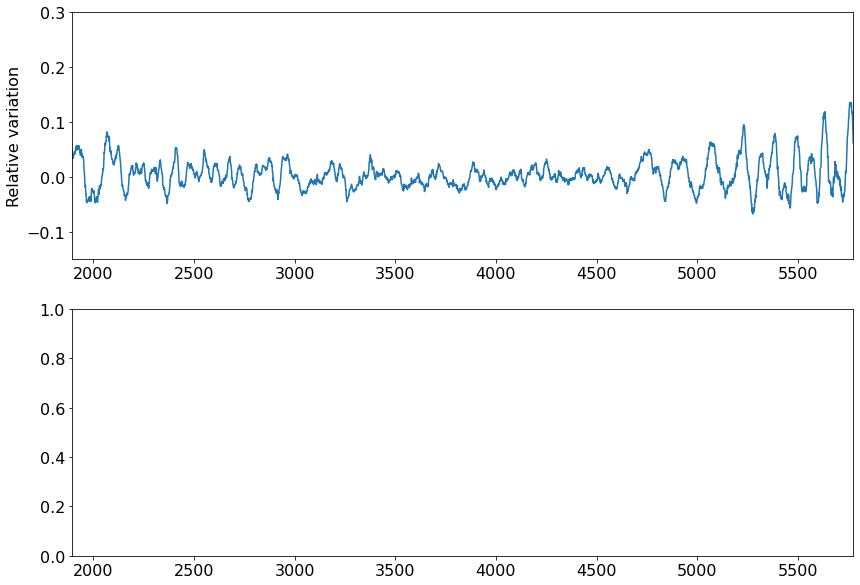

In [44]:
normalize = True

dynpower = []
window = 500
lo,hi = np.percentile(pos[np.isfinite(v)], [20,96])
periods = np.arange(20.0, 250.0, 0.1)

for _ in np.linspace(lo, hi-window, 100):
    idx = np.isfinite(v) & (pos >= _) & (pos < _+window)
    power = lombscargle(pos[idx], v[idx], 2*np.pi/periods, normalize=normalize, precenter=False)
    dynpower.append(power)
    
dynpower = np.array(dynpower).T
extent = [lo,hi,periods[0],periods[-1]]

ax=plt.subplot(211)
plt.plot(pos, v)
plt.xlim(lo,hi)
plt.ylabel('Relative variation')
#plt.title('%s, bias %g V, %.0f nm' % (header['LSST_NUM'], header['CCDBSS'], header['MONOCH-WAVELENG']))
plt.ylim(-0.0015*100,0.0030*100)

plt.subplot(212, sharex=ax)
imshow(dynpower, [0.5, 99.0], aspect='auto', extent=extent, interpolation='bicubic', show_colorbar=False)
plt.xlabel('Radius, pix')
plt.ylabel('Period, pixels')
if normalize:
    plt.title('Normalized power vs time, %g pix window' % window)
else:
    plt.title('Unnormalized power vs time, %g pix window' % window)
# plt.yscale('log')


## Noise Level

In [86]:
noise_e2v = tree_ring_tools(sensor='e2v',loc=3)

noise_e2v.img_cut = 100.*imp.fit_transform(dt_im)
noise_e2v.img     = 100.*dt_im

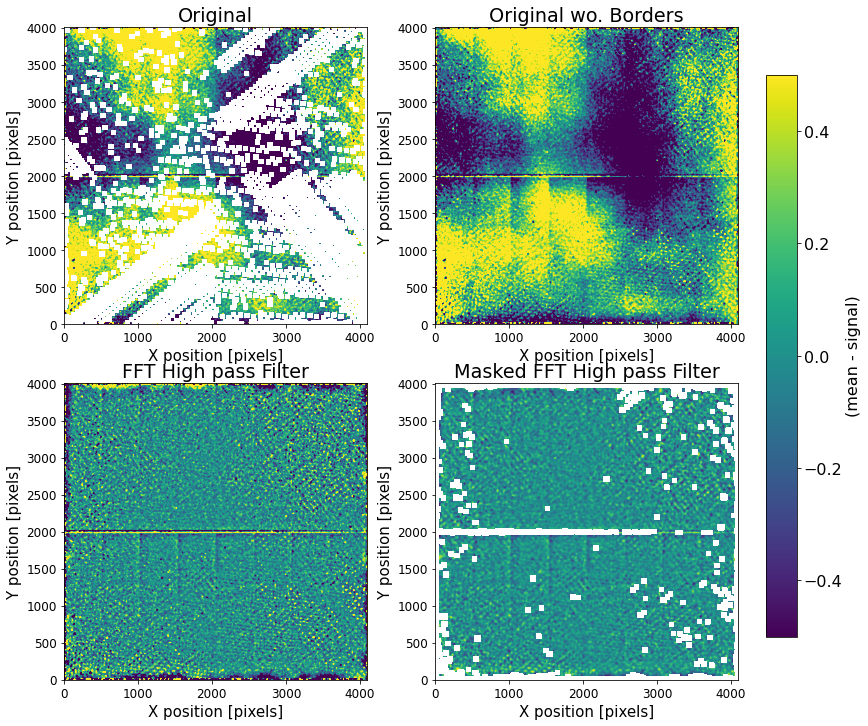

In [87]:
## always run in the following order
noise_e2v.apply_high_freq_filter()
noise_e2v.apply_gaussian_filter(downscale=8)
noise_e2v.apply_mask(downscale=8,threshold=0.75)

# noise_e2v.diff2 = noise_e2v.diff#gaussian_filter(noise_e2v.diff,8)

noise_e2v.set_ylabel(r'(mean - signal)')
noise_e2v.set_levels([-0.5,0.5])
noise_e2v.display_images()

In [91]:
noise_e2v.xc = 4620.
noise_e2v.yc = -470.

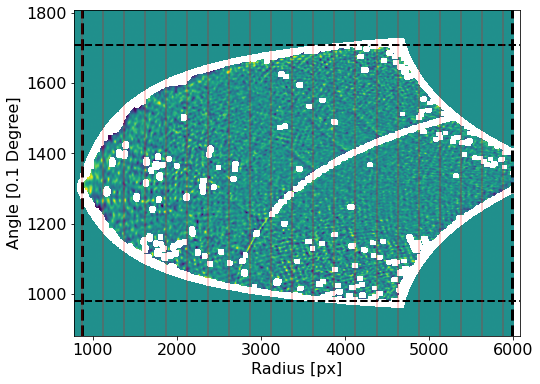

In [95]:
noise_e2v.set_levels([-0.45,0.45])
# noise_e2v.theta_min = 1150
# noise_e2v.theta_max = 1600
noise_e2v.make_polar_transformation(rborder=20.)
noise_e2v.check_polar_transfomartion()
# plt.xlim(2000.,5500)
# plt.ylim(1300,1700)

(3100.0, 5107.0)

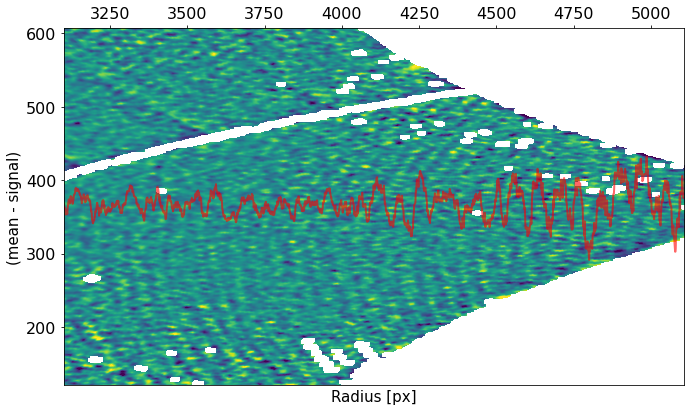

In [96]:
noise_e2v.compute_signal(zeroNan=True)
noise_e2v.plot_superposition_polar_signal()
plt.xlim(3100,)


(-0.45, 0.45)

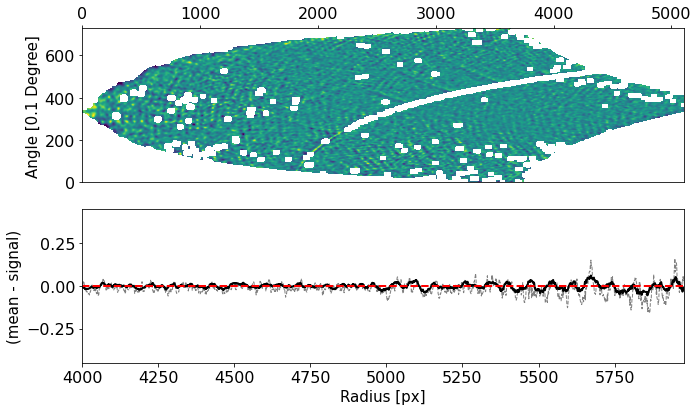

In [97]:
noise_e2v.plot_pannel_image_signal()
plt.xlim(4000,)
plt.ylim(-0.45,0.45)

(-0.5, 0.5)

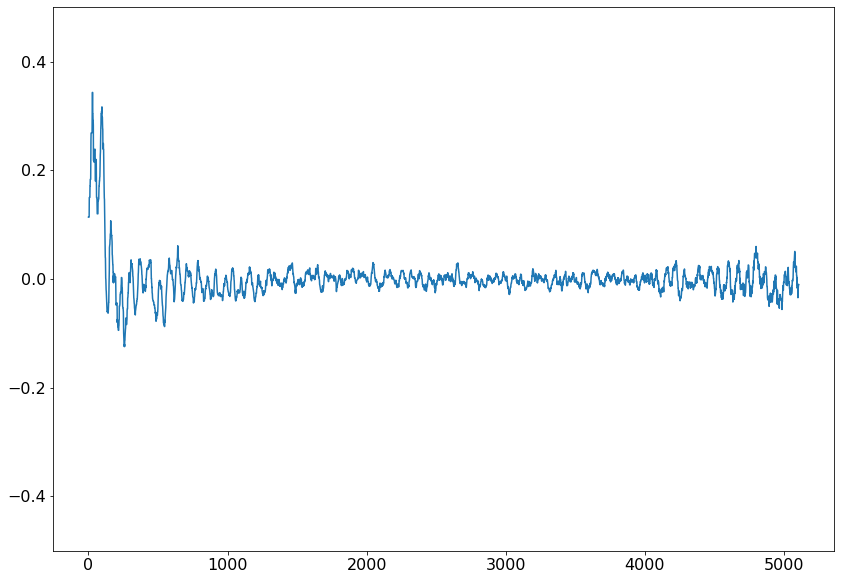

In [99]:
plt.plot(noise_e2v.signal)
# plt.xlim(200,)
plt.ylim(-0.5,0.5)

In [165]:
noise_e2v.save_profile('dtheta2')

saving: profiles/polar_e2v_dtheta2.npy


### Compare Signal

In [155]:
def plot_profile(self,axes,color='k',label='_'):
#     axes.plot(self.radii,self.signal0,'grey',lw=1,ls='--')
    axes.plot(self.radii,self.signal,color,lw=2,label=label)
    axes.axhline(0,color='r',ls='--',lw=2)
    axes.set_xlim(xmin=min(self.radii),xmax=max(self.radii))
    axes.set_xlabel("Radius [px]",fontsize=15)

# def plot_profile(self,ax=None,color=None,unit='pixel',label="",fill=True,factor=1.,percentage=False,alpha=0.8):
#     sm = np.nanpercentile(self.polar_cut,25,0)
#     sp = np.nanpercentile(self.polar_cut,75,0)
#     out = [self.radii,self.signal,self.signal,sm,sp]
#     x,y,ym,yp = out[0], out[1], out[3], out[4]
    
#     pr=1.
#     if percentage: pr=100.
        
#     if ax is None: ax=plt.axes()
#     p     = ax.plot(x, factor*y*pr, lw=2, color=color,label=label,alpha=alpha)
#     ax.plot(x,0.*x, 'k',ls=(0, (3, 10, 1, 10)),lw=2)
#     color = p[0].get_color()
#     if fill:    ax.fill_between(x,factor*pr*ym,factor*pr*yp,alpha=0.3, label=None, color=color)
        
#     ax.set_xlabel('radii [pixels]')
#     ax.set_ylabel('dev. from mean [%s]'%(unit))

In [156]:
rms_ring = np.std(ring_e2v.signal[1500:])
rms_noise = np.std(noise_e2v.signal[1500:])

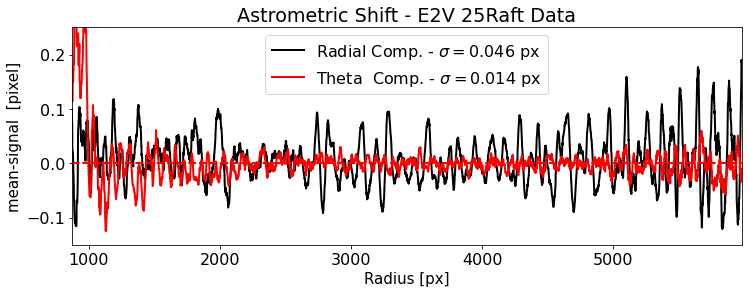

In [158]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

plot_profile(ring_e2v,axes,label=r'Radial Comp. - $\sigma = %.3f$ px'%(rms_ring))
plot_profile(noise_e2v,axes,color='r',label=r'Theta  Comp. - $\sigma = %.3f$ px'%(rms_noise))

axes.legend()
axes.set_ylim(-0.15,0.25)
axes.set_ylabel('mean-signal  [pixel]',fontsize=15)
plt.title('Astrometric Shift - E2V 25Raft Data')
plt.savefig('compare_e2v_astro_shift_signal.png')

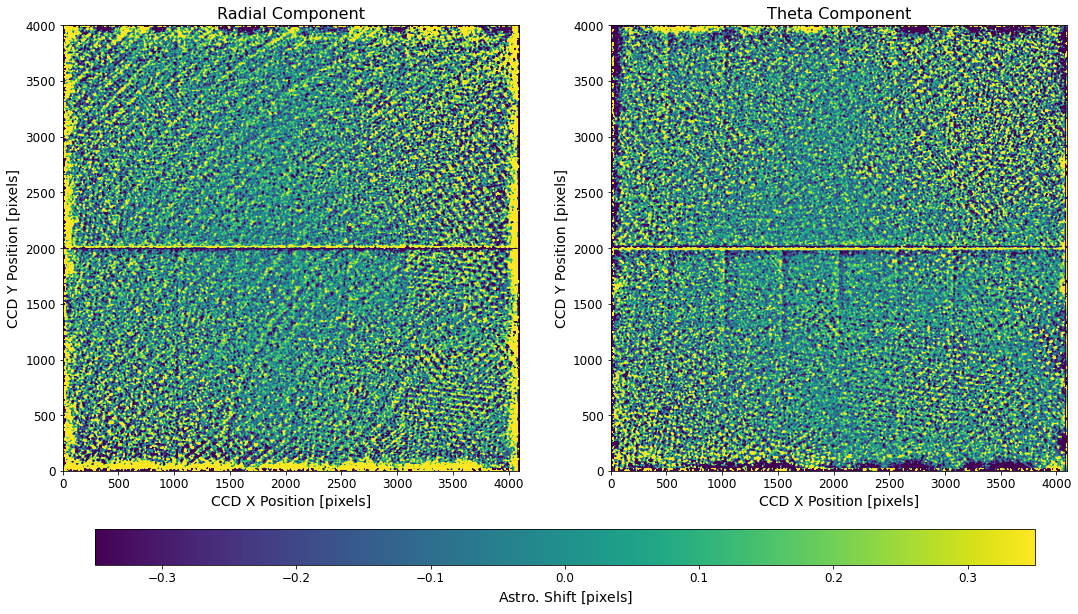

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(18, 10))

im0 = imshow(ring_e2v.diff,ax[0],show_colorbar=True,levels=[-0.35,0.35])
imshow(noise_e2v.diff,ax[1],levels=[-0.35,0.35])

ax[0].set_title('Radial Component', fontsize=16)
ax[0].set_ylabel('CCD Y Position [pixels]', fontsize=14)
ax[0].set_xlabel('CCD X Position [pixels]', fontsize=14)
ax[0].tick_params(axis='both', which='major', labelsize=12)

ax[1].set_title('Theta Component', fontsize=16)
ax[1].set_ylabel('CCD Y Position [pixels]', fontsize=14)
ax[1].set_xlabel('CCD X Position [pixels]', fontsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=12)

fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.15, 0.1, 0.725, 0.05])
cbar = fig.colorbar(im0, cax=cbar_ax, orientation='horizontal')
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'Astro. Shift [$\mathrm{pixels}$]', fontsize=14)
fig.patch.set_facecolor('white')
plt.savefig('compare_e2v_astro_shift_image.png')